# Trying to convert llama outputs to something useful

In [1]:
# LLama character-based compression

from transformers import LlamaForCausalLM, LlamaTokenizer, GenerationConfig
import pandas as pd
import numpy as np
import utils
import audioop
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda')
tokenizer = LlamaTokenizer.from_pretrained(
    'meta-llama/Llama-2-7b-hf',
    use_fast = False,
    padding=True,
)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = 'left'
model = LlamaForCausalLM.from_pretrained('meta-llama/Llama-2-7b-hf', device_map = 'auto')

/home/mattf/anaconda3/envs/llmcomp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_330037/3824836917.py:7: DeprecationWarning: 'audioop' is deprecated and slated for removal in Python 3.13
  import audioop
Loading checkpoint shards: 100%|██████████| 3/3 [00:12<00:00,  4.04s/it]


In [3]:
raw_data = np.fromfile(f'data/test/w_test.data', dtype = np.int16)
data_iq = raw_data[0::2] + 1j*raw_data[1::2]
signal_real = np.real(data_iq).copy().astype(np.int16) 
signal_real = signal_real.tobytes()
biased = audioop.lin2lin(signal_real, 2, 1)
data = audioop.bias(biased, 1, 2**7)
ndata = np.frombuffer(data, dtype = np.uint8)
data = np.right_shift(ndata, 1)

offset = 0
in_size = 2048
cdata = data[offset:in_size+offset]
fulldata = data[offset:in_size+offset+16]
tk = tokenizer(cdata.tobytes().decode('ascii'))['input_ids']

In [4]:
from torch import cat
cdata_s = ''.join(chr(x) for x in cdata)
cdata_list = [cdata_s[:i] for i in range(len(cdata_s))]
cdata_list
# Actually want subtstrings of the tokenized version
tk = tokenizer(cdata_s, return_tensors='pt', padding = True)
#tk = tokenizer(cdata_list, return_tensors='pt', padding = True)
#tk['input_ids'].shape
#cat(tk['input_ids'], tk['input_ids'][0])
#tk['input_ids'] = cat((tk['input_ids'], tk['input_ids']), 0)
#tk

ntk = {}
ntk['input_ids'] = tk['input_ids']
for i in range(1, len(tk['input_ids'][0])):
    ntk['input_ids'] = cat((ntk['input_ids'], tk['input_ids']), 0)

def create_lower_diagonal_ones_tensor(size):
    # Create a square matrix of ones
    ones_matrix = torch.ones((size, size), dtype=torch.int)
    
    # Use the lower triangular part of the ones matrix
    lower_diag_matrix = torch.tril(ones_matrix)
    
    return lower_diag_matrix

# Example usage
size =28  # Specify the size of the matrix
lower_diag_ones_tensor = create_lower_diagonal_ones_tensor(size)
ntk['attention_mask'] = lower_diag_ones_tensor
ntk['attention_mask']

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [5]:
inputs = tokenizer(cdata_list, return_tensors='pt', padding = True)
inputs['input_ids'][0],inputs['attention_mask'][0]

(tensor([0, 0, 0,  ..., 0, 0, 1]), tensor([0, 0, 0,  ..., 0, 0, 1]))

In [6]:
# instead of creating a diag make a sequence
offset = 0
in_size = 2048
cdata = data[offset:in_size+offset]
cdata_s = ''.join(chr(x) for x in cdata)

tk = tokenizer(cdata_s)
len(tk['input_ids'])

def create_sliding_window_tensors_with_mask(input_tensor, window_size, num_windows):
    # Number of tensors we can create from the sliding window
    #num_windows = input_tensor.size(0) - window_size + 1
    sliding_windows = []
    mask_tensors = []
    symbols = []

    # Create sliding windows and corresponding mask tensors
    for i in range(num_windows):
        # Get the window
        window = input_tensor[i:i + window_size].clone()
        symbols.append(input_tensor[i+window_size].item())
        window[0] = 1
        sliding_windows.append(window)
        
        # Create the mask (all ones, with the first value as a start token)
        mask = torch.ones(window_size, dtype=torch.int)
        mask[0] = 1  # Ensure the first value in the mask is 1 (start token)
        mask_tensors.append(mask)

    return torch.stack(sliding_windows), torch.stack(mask_tensors), symbols
    
tks, msks, symbols = create_sliding_window_tensors_with_mask(torch.tensor(tk['input_ids']), 256, 16)
ntk = {}
ntk['input_ids'] = tks
ntk['attention_mask'] = msks

ntk['input_ids'].shape


torch.Size([16, 256])

19


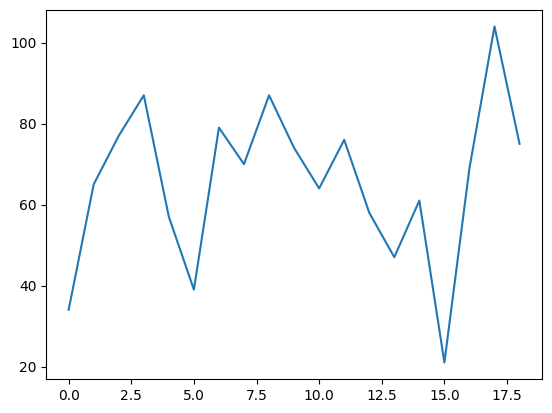

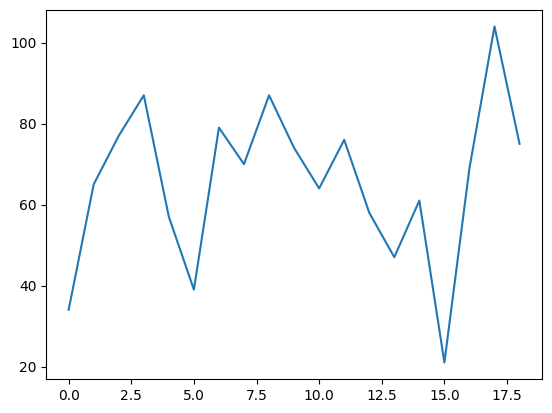

: 

In [34]:
rv = tokenizer.decode(symbols)
rvv = [ord(x) for x in rv]
print(len(rvv))
plt.figure()
plt.plot(rvv)
plt.show()

pv = tokenizer.decode(tk['input_ids'][256:])
pvv = [ord(x) for x in pv]
plt.figure()
plt.plot(pvv[0:19])
plt.show()


In [16]:
len(tokenizer.decode(symbols))

19

: 

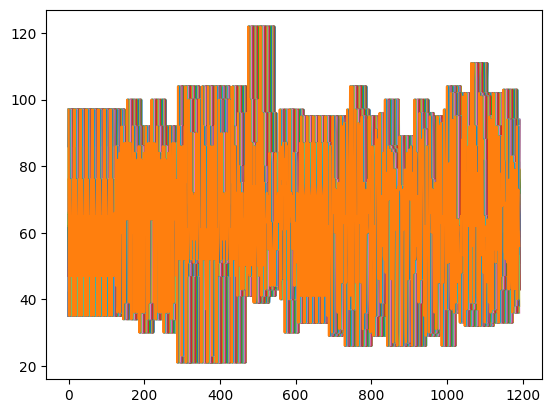

In [70]:
bk = list()
for i in tks[:, 1:]:
    bk.append([ord(x) for x in tokenizer.decode(i)])

for i in bk:
    plt.plot(i)


In [4]:
# From big G
import torch

def create_masked_tensors(tokens):
    # Convert the list of tokens to a tensor
    tokens_tensor = torch.tensor(tokens)
    size = len(tokens)

    # Create the masked tensor
    masked_tensor = []
    mask_tensor = []
    
    # Create the left-padded masked version and mask
    for i in range(size):
        # Left-pad the tokens with zeros
        padded = torch.cat((torch.zeros(i, dtype=torch.int), tokens_tensor[:size - i]))
        masked_tensor.append(padded)
        
        # Create the mask: 1 where tokens exist, 0 where padding
        mask = torch.cat((torch.zeros(i, dtype=torch.int), torch.ones(size - i, dtype=torch.int)))
        mask_tensor.append(mask)

    # Convert lists to tensors
    masked_tensor = torch.stack(masked_tensor)
    mask_tensor = torch.stack(mask_tensor)

    return masked_tensor, mask_tensor

# Example usage
tokens = tokenizer(cdata_s, return_tensors='pt', padding = True)['input_ids'][0]
print(tokens)
masked_tensor, mask_tensor = create_masked_tensors(tokens)

print("Masked Tensor:")
print(masked_tensor.shape)

print("\nMask Tensor:")
print(mask_tensor.shape)

ntk = {}
ntk['attention_mask'] = mask_tensor.flip(0)
ntk['input_ids'] = masked_tensor.flip(0)

tensor([    1,   334, 29937,  ..., 29946, 29902,   259])
Masked Tensor:
torch.Size([1779, 1779])

Mask Tensor:
torch.Size([1779, 1779])


/tmp/ipykernel_298255/3908742058.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_tensor = torch.tensor(tokens)


In [6]:
@torch.no_grad()
def evaluate():

    generation_config = GenerationConfig(
    temperature=0.7,
    top_p= 0.75,
    top_k = 32000,
    num_beams=1,
    do_sample = False,
    output_logits = True,
    )

    with torch.no_grad():
        generation_output = model.generate(
            **ntk,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            output_logits = True,
            max_new_tokens=1,
        )
    return generation_output

rp = evaluate()

/home/mattf/anaconda3/envs/llmcomp/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/mattf/anaconda3/envs/llmcomp/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.75` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/mattf/anaconda3/envs/

In [7]:
#cdata_list[-1], tokenizer.batch_decode(rp['sequences'], skip_special_tokens=False)
#rp

import gc
torch.cuda.empty_cache()
gc.collect()

with torch.no_grad():
    torch.cuda.empty_cache()

In [8]:
from torch.nn import functional as F
import torch

#symbols = [i.item() for i in tk['input_ids'][0][1:]]

torch_logits = rp['logits'][0]

print(torch_logits.shape)
# get probabilities using softmax from logit score and convert it to numpy array
probabilities_scores = F.softmax(torch_logits, dim = -1).numpy()
pdfs = probabilities_scores[0:-1, :]
pdfs = pdfs.tolist()


torch.Size([16, 32000])


In [12]:
# Now we have probs and that let's encode
output = list()
import arithmetic_coder
encoder = arithmetic_coder.Encoder(
    base=2,
    precision=32,
    output_fn=output.append,
)

for symbol, pdf in zip(symbols, pdfs):
    encoder.encode(utils.normalize_pdf_for_arithmetic_coding(pdf), symbol)

encoder.terminate()

compressed_bits = ''.join(map(str, output))
compressed_bytes, padding = utils.bits_to_bytes(compressed_bits)

print(compressed_bits)
print(len(compressed_bits))
print(len(compressed_bytes))
print((len(compressed_bytes) + 2 )/ 16)

011100111110000011000000101100000001101011110100011101110010010110000010100110010011111100001000100110
102
13
0.9375


NameError: name 'model' is not defined

: 

In [25]:
# Try arithmetic coding

pdf = utils.normalize_pdf_for_arithmetic_coding(probabilities_scores)
output = list()
import arithmetic_coder
encoder = arithmetic_coder.Encoder(
    base=2,
    precision=32,
    output_fn=output.append,
)

encoder.encode(utils.normalize_pdf_for_arithmetic_coding(pdf), 363)
compressed_bits = ''.join(map(str, output))
compressed_bits

'1'

In [67]:
# Try with 32 inputs from data
cdata

NameError: name 'cdata' is not defined

In [36]:
import pickle
import numpy as np
import utils
import torch
import gc
import matplotlib.pyplot as plt

with open('in_pdf.pkl', 'rb') as f:
    in_pdf = np.array(pickle.load(f))

with open('out_pdf.pkl', 'rb') as f:
    out_pdf = np.array(pickle.load(f))

cutoff=31
in_pdf = in_pdf[0:cutoff]
out_pdf = out_pdf[0:cutoff]


real_symbols = [29963, 29929, 29945, 28062, 29890, 29946, 29902, 29871, 360, 29936, 33, 29963, 29934, 29936, 29984, 29936, 29899, 29992, 29902, 29973, 29947, 29995, 29966, 29925, 29961, 29906, 29950, 20449, 29946, 29987, 16359, 29901]

import arithmetic_coder

# Load in data
with open('compressed_llama.data', 'rb') as f:
    d = f.read()
print(d)

import sys
import traceback
data_iter = iter(utils.bytes_to_bits(d, num_padded_bits=4))

from typing import Iterator
def _input_fn(bit_sequence: Iterator[str] = data_iter) -> int | None:
    try:
        return int(next(bit_sequence))
    except StopIteration:
        return None
decoder = arithmetic_coder.Decoder(
    base=2,
    precision=32,
    input_fn=_input_fn,
)
token_list = list()
for idx in range(22):
    torch.cuda.empty_cache()
    gc.collect()
    try:
        token = decoder.decode(
            utils.normalize_pdf_for_arithmetic_coding(out_pdf[idx])
        )
    except Exception as e:
        traceback.print_exc()
        break
    token_list.append(token)





b'iZf\xe3\xfa\xef)Xd'


Traceback (most recent call last):
  File "/tmp/ipykernel_332815/45984347.py", line 48, in <module>
    token = decoder.decode(
            ^^^^^^^^^^^^^^^
  File "/home/mattf/llmcomp/arithmetic_coder.py", line 309, in decode
    return self._process(pdf, None)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mattf/llmcomp/arithmetic_coder.py", line 217, in _process
    assert 0 <= symbol < pdf.size, f'symbol was {symbol}'
           ^^^^^^^^^^^^^^^^^^^^^^
AssertionError


In [34]:
for i in range(len(token_list)):
    print(f'{i}: {real_symbols[i]} | {token_list[i]}')

0: 29963 | 29963
1: 29929 | 29929
2: 29945 | 29945
3: 28062 | 28062
